In [8]:
import h5py
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np

from unet3d import Unet3D
from diffuser import GaussianDiffusion

In [2]:
from data import NaiverStokes_Dataset

In [3]:
ds = NaiverStokes_Dataset('../../data/ns_V1e-5_T20_test.h5')

Loaded 200 samples from ../../data/ns_V1e-5_T20_test.h5


In [6]:
denoising_fn = Unet3D(
            channels=1,
            cond_channels=1,
            channel_mults=(1, 2, 4, 8),
            init_conv_channels=32,
            init_conv_kernel_size=5
)

diffuser = GaussianDiffusion(
    denoising_fn=denoising_fn,
    sample_size=(1, 20, 64, 64),
    n_diffusion_steps=1000
).cuda(0)

In [7]:
diffuser.denoising_fn.load_state_dict(torch.load('./ckpts/ns_V1e-5_T20/ckpt.pt')['model_state_dict'])

<All keys matched successfully>

In [17]:
n = np.random.randint(0, len(ds))
x = ds[n]['x']
x_pred = diffuser.sample(cond=ds[n]['y'].unsqueeze(0))

DDPM sampling: 100%|██████████| 1000/1000 [00:47<00:00, 20.83it/s]


In [18]:
x_pred = x_pred.detach().cpu()

In [19]:
x_pred = x_pred.squeeze()
x = x.squeeze()

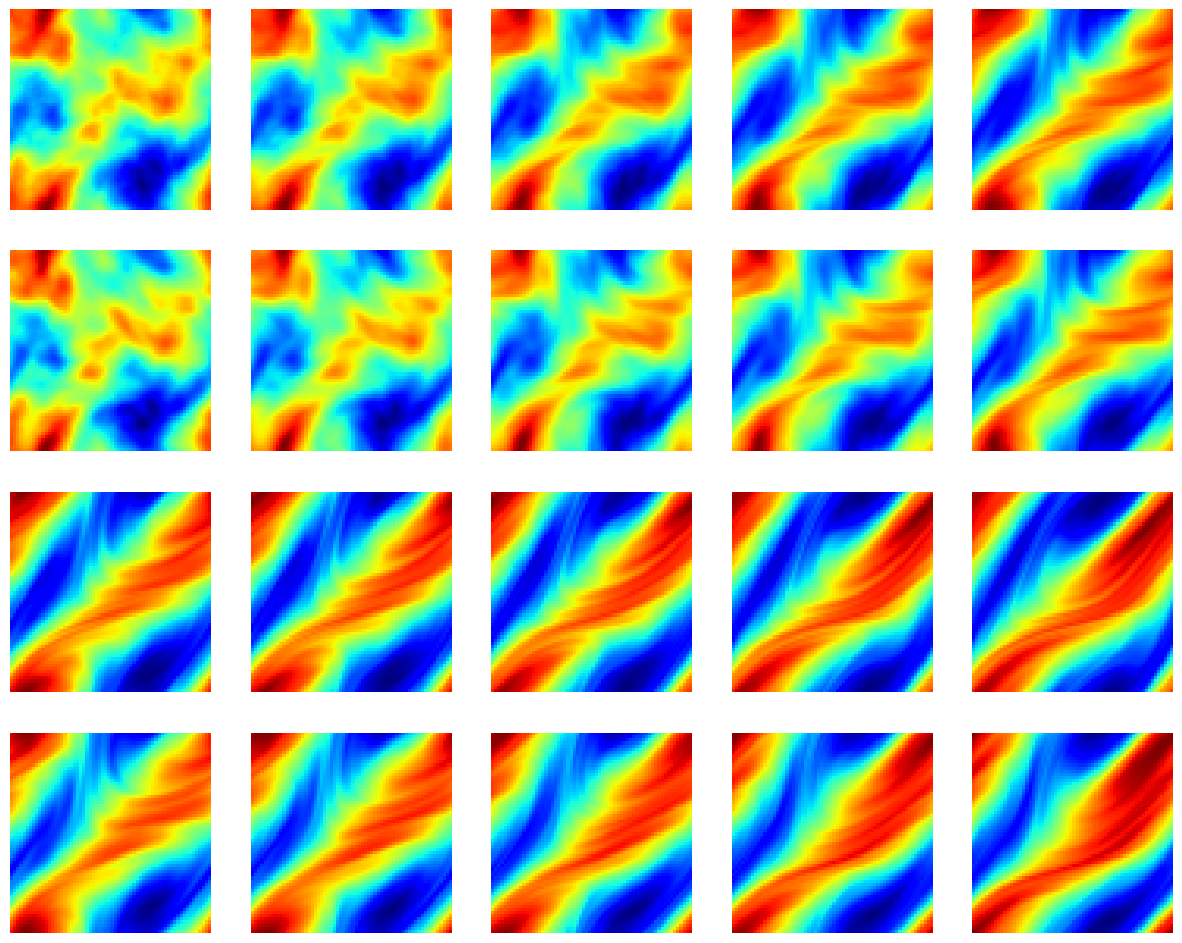

In [20]:
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
for i in range(5):
    ax[0, i].imshow(x[i], cmap='jet')
    ax[0, i].axis('off')
    ax[1, i].imshow(x_pred[i], cmap='jet')
    ax[1, i].axis('off')
    ax[2, i].imshow(x[i+5], cmap='jet')
    ax[2, i].axis('off')
    ax[3, i].imshow(x_pred[i+5], cmap='jet')
    ax[3, i].axis('off')
    

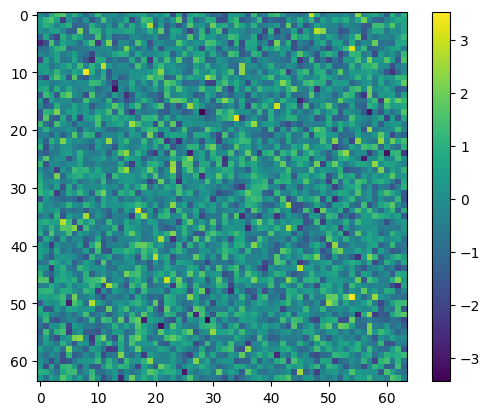

In [42]:
plt.imshow(torch.randn((64, 64)))
plt.colorbar()